### Fetch MNIST dataset

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
print("X:", X.shape)
print("y:", y.shape)

X: (70000, 784)
y: (70000,)


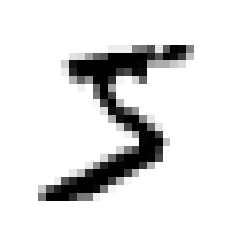

y= 5


In [3]:
# take a look at the 'data'
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()
print("y=", y[0])

In [4]:
import numpy as np

y=y.astype(np.uint8)

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### train a classifier to recognize 5s

In [6]:
#true and false if the target is a 5
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [7]:
#create and train a stochastic gradient descent classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [8]:
#does it work on our 5 above?
print("Is it 5?",sgd_clf.predict([some_digit]))

Is it 5? [ True]


### measure accuracy with cross-validation

In [9]:
#custom implemenation of cross-validation (similar to scikit-learn's cross_val_score)
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


In [10]:
#use cross_val_score() to evaluate the model
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

In [11]:
#how about we make our own classifier to make everything 'not 5'
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)


In [12]:
#this is 'accurate' because only ~ 10% of the data are 5s
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

# Confusion matrix
#                 |    Not 5 predictions         |    5 Predications         |
# Actual Not 5's  | not 5's correctly identified | not 5's classified as 5's |
# Actual 5's      | 5's classified as not 5's    | 5's correctly identified  |

array([[53892,   687],
       [ 1891,  3530]])

In [14]:
# precision = True Positive/(True Positive + False Positive)
# recall/sensitivity/true positive rate = True Positive/(True Positive + False Negative)
# Confusion matrix redux
#           |  Negative      |  Positive      |
# Negative  | True Negative  | False Positive |
# Positive  | False Negative | True Positive  |

from sklearn.metrics import precision_score, recall_score
print("Precision",precision_score(y_train_5, y_train_pred))
print("Sensitivity",recall_score(y_train_5, y_train_pred))

Precision 0.8370879772350012
Sensitivity 0.6511713705958311


In [15]:
#F1 score (or harmonic mean)
# F1 = 2/((1/precision)+(1/recall))=True Positive/(True Positive + ((False Negative + False Positive)/2))
from sklearn.metrics import f1_score
print("F1 Score:",f1_score(y_train_5, y_train_pred))

F1 Score: 0.7325171197343846


In [16]:
#look at the sgd decision score
y_scores = sgd_clf.decision_function([some_digit])
print("Decision score:", y_scores)

#sgd compares the decision score to a threshold to classify something
#you could classify it manually like this:
threshold = 100
print("Over threshold?", (y_scores > threshold))

Decision score: [2164.22030239]
Over threshold? [ True]


In [17]:
# return decision scores rather than predications (method=decision_function)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")


In [18]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

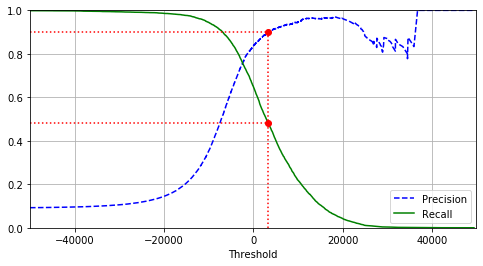

In [19]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.grid()
    plt.legend()
    plt.axis([-50000,50000,0,1])



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  # Not shown

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown

plt.show()


No handles with labels found to put in legend.


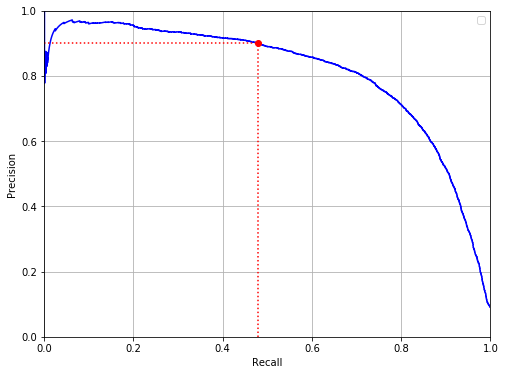

In [20]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid()
    plt.legend()
    plt.axis([0,1,0,1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4798, 0.4798], [0., 0.9], "r:")   #for magic numbers see recall_score below
plt.plot([0.0, 0.4798], [0.9, 0.9], "r:")
plt.plot([0.4798], [0.9], "ro")

plt.show()

In [21]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print("Precision:",precision_score(y_train_5, y_train_pred_90))
print("Recall:",recall_score(y_train_5, y_train_pred_90))

Precision: 0.9000345901072293
Recall: 0.4799852425751706


### ROC Curve

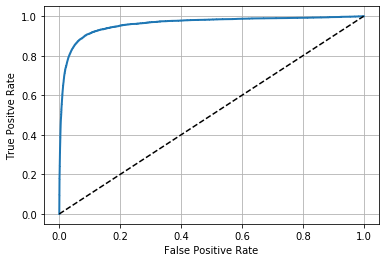

In [22]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.grid()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positve Rate")

plot_roc_curve(fpr,tpr)
plt.show()

In [23]:
from sklearn.metrics import roc_auc_score
print("ROC AUC:", roc_auc_score(y_train_5, y_scores))

ROC AUC: 0.9604938554008616


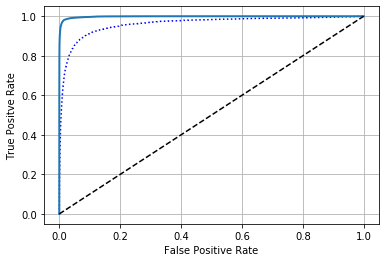

Forest ROC AUC: 0.9983436731328145


In [24]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

#print("y probabilities:", y_probas_forest)

y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.show()

print("Forest ROC AUC:", roc_auc_score(y_train_5, y_scores_forest))

### Multiclass classification

In [25]:
#support vector machine (default to OvO strategy)
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
print("SVM:", svm_clf.predict([some_digit]))

SVM: [5]


In [26]:
#look at the scores to observe OvO in action (5 has the highest score)
some_digit_scores = svm_clf.decision_function([some_digit])
print("Decision scores:", some_digit_scores)

Decision scores: [[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]


In [27]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

print("OvR prediction:",ovr_clf.predict([some_digit]))

OvR prediction: [5]


In [28]:
sgd_clf.fit(X_train, y_train)
print("SGD prediction", sgd_clf.predict([some_digit]))
print("SGD Decision Scores:", sgd_clf.decision_function([some_digit]))

SGD prediction [3]
SGD Decision Scores: [[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]


In [29]:
print("Cross Val Score:", cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy"))

Cross Val Score: [0.87365 0.85835 0.8689 ]


In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
print("Scaled input cross val score:",cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy"))

Scaled input cross val score: [0.8983 0.891  0.9018]


### Error Analysis

In [31]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix:",conf_mx)

Confusion Matrix: [[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


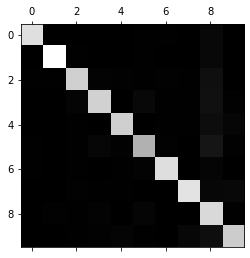

In [32]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

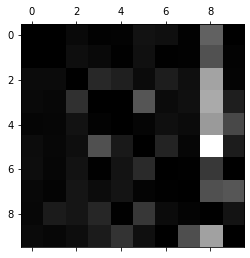

In [33]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [34]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

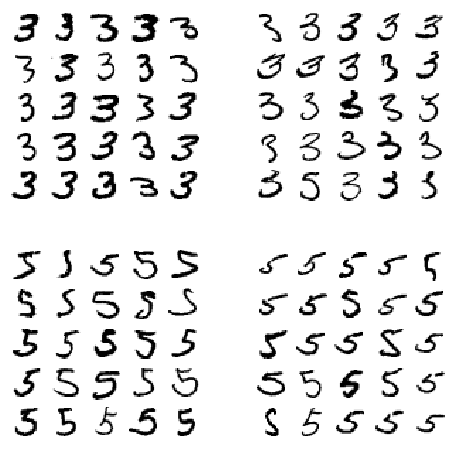

In [35]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train==cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train==cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train==cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train==cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

### Multilabel Classification

In [36]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [37]:
print("KNN Prediction:", knn_clf.predict([some_digit]))

KNN Prediction: [[False  True]]


In [38]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
print("F1 Score",f1_score(y_multilabel, y_train_knn_pred, average="macro"))

F1 Score 0.976410265560605


### Multioutput Classification

In [39]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [40]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

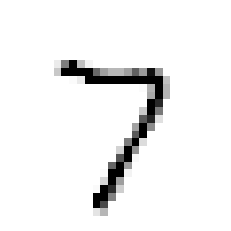

In [42]:
some_index = 0
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)